In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import time

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
movies_content = pd.read_csv('Data/movies_metadata.csv').filter(items=['id','genres']).drop([19730, 29503, 35587])
movies_content['id'] = movies_content['id'].astype('int64')
movies_content.drop_duplicates(subset='id', keep='first', inplace=True)
movies_content.head()

,id,genres
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,"[{'id': 35, 'name': 'Comedy'}]"


In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

movies_content['genres'] = movies_content['genres'].apply(get_text)

movies_content.head()

,id,genres
0,862,"Animation, Comedy, Family"
1,8844,"Adventure, Fantasy, Family"
2,15602,"Romance, Comedy"
3,31357,"Comedy, Drama, Romance"
4,11862,Comedy


In [ ]:
def separate(text):
    clean_text = []
    for t in text.split(','):
        cleaned = re.sub('\(.*\)', '', t) # Remove text inside parentheses
        cleaned = cleaned.translate(str.maketrans('','', string.digits))
        cleaned = cleaned.replace(' ', '')
        cleaned = cleaned.translate(str.maketrans('','', string.punctuation)).lower()
        clean_text.append(cleaned)
    return ' '.join(clean_text)

def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower()
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [ ]:

movies_content['genres'] = movies_content['genres'].apply(remove_punc)

movies_content['genres'] = movies_content[movies_content.columns[1:]].apply(lambda x: ' '.join(x), axis=1)
movies_content.set_index('id', inplace=True)

movies_content.head()

,genres
id,
862,animation comedy family
8844,adventure fantasy family
15602,romance comedy
31357,comedy drama romance
11862,comedy


In [ ]:
ratings = pd.read_csv('Data/ratings_small.csv').filter(items=['userId', 'movieId', 'rating'])
ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [ ]:
list_of_movies_with_ratings = ratings['movieId'].unique()

list_of_movies_with_content = movies_content.index.tolist()

movies = list(set(list_of_movies_with_ratings).intersection(set(list_of_movies_with_content)))
movies.sort()
print(movies)
print(len(movies))

[2, 3, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 35, 38, 55, 58, 59, 62, 63, 64, 65, 66, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118, 121, 122, 123, 124, 129, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 186, 187, 189, 193, 194, 195, 196, 198, 199, 200, 201, 203, 204, 205, 206, 207, 211, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 285, 287, 288, 289, 290, 291, 292, 293, 294, 2

In [ ]:
ratings = ratings[ratings['movieId'].isin(movies)]
ratings.head()

,userId,movieId,rating
10,1,1371,2.5
11,1,1405,1.0
13,1,2105,4.0
15,1,2193,2.0
16,1,2294,2.0


In [ ]:
content = movies_content.loc[movies]
content.shape

(2830, 1)

In [ ]:
genres = []
for i in content['genres']:
    genres.extend(i.split())
genres = list(set(genres))
print(genres)

['horror', 'crime', 'fantasy', 'thriller', 'science', 'history', 'western', 'action', 'comedy', 'mystery', 'fiction', 'documentary', 'war', 'movie', 'tv', 'animation', 'adventure', 'drama', 'family', 'music', 'romance', 'foreign']


In [ ]:
genres_size = len(genres)
content_matrix = np.zeros((content.shape[0], genres_size))
row = 0
for i in content['genres']:
    for genre in i.split():
        content_matrix[row, genres.index(genre)] = 1
    row += 1

content_matrix.shape

(2830, 22)

In [ ]:
users_number = ratings['userId'].nunique()
movies_number = ratings['movieId'].nunique()

ratings.shape
rating_matrix = np.zeros((users_number, movies_number))

for user_id, movie_id, rating in ratings.values:
    rating_matrix[int(user_id) - 1, movies.index(movie_id)] = rating

rating_matrix.shape

(671, 2830)

In [ ]:
def mask(corruption_level ,size):
    mask = np.random.binomial(1, 1 - corruption_level, [size[0],size[1]])
    return mask

def add_noise(x , corruption_level ):
    x = x * mask(corruption_level , x.shape)
    return x

In [ ]:
class CDL():
    def __init__(self , rating_matrix , item_information_matrix):

        # model參數設定
        self.n_input = item_information_matrix.shape[1]
        self.n_hidden1 = 200
        self.n_hidden2 = 50
        self.k = 50

        self.lambda_w = 0.1
        self.lambda_n = 10
        self.lambda_u = 1
        self.lambda_v = 10

        self.drop_ratio = 0.1
        self.learning_rate = 0.01
        self.epochs = 200
        self.batch_size = 256

        self.a = 1
        self.b =0.01
        self.P = 1

        self.num_u = rating_matrix.shape[0]
        self.num_v = rating_matrix.shape[1]

        self.Weights = {
            'w1' : tf.Variable(tf.truncated_normal( [self.n_input , self.n_hidden1] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w2' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_hidden2] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w3' : tf.Variable(tf.truncated_normal( [self.n_hidden2 , self.n_hidden1] , mean=0.0, stddev= tf.truediv(1.0,self.lambda_w))),
            'w4' : tf.Variable(tf.truncated_normal( [self.n_hidden1 , self.n_input] , mean=0.0,  stddev= tf.truediv(1.0,self.lambda_w)))
        }
        self.Biases = {
            'b1' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),
            'b2' : tf.Variable( tf.zeros(shape=self.n_hidden2) ),
            'b3' : tf.Variable( tf.zeros(shape=self.n_hidden1) ),
            'b4' : tf.Variable( tf.zeros(shape=self.n_input) ),
        }

        self.item_information_matrix = item_information_matrix

        self.rating_matrix = rating_matrix

        for i in range(self.num_u):
            x = np.random.choice(np.where(self.rating_matrix[i,:]>0)[0] , self.P)
            self.rating_matrix[i,:].fill(0)
            self.rating_matrix[i,x] = 1

        self.confidence = np.mat(np.ones(self.rating_matrix.shape)) * self.b
        self.confidence[np.where(self.rating_matrix>0)] = self.a

    def encoder(self , x , drop_ratio):
        w1 = self.Weights['w1']
        b1 = self.Biases['b1']
        L1 = tf.nn.sigmoid( tf.matmul(x,w1) + b1 )
        L1 = tf.nn.dropout( L1 , keep_prob= 1 - drop_ratio )

        w2 = self.Weights['w2']
        b2 = self.Biases['b2']
        L2 = tf.nn.sigmoid( tf.matmul(L1,w2) + b2 )
        L2 = tf.nn.dropout(L2 , keep_prob= 1 - drop_ratio)

        return L2

    def decoder(self , x , drop_ratio):
        w3 = self.Weights['w3']
        b3 = self.Biases['b3']
        L3 = tf.nn.sigmoid(tf.matmul(x,w3) + b3)
        L3 = tf.nn.dropout(L3 , keep_prob= 1 - drop_ratio)

        w4 = self.Weights['w4']
        b4 = self.Biases['b4']
        L4 = tf.nn.sigmoid(tf.matmul(L3,w4) + b4)
        L4 = tf.nn.dropout(L4 , keep_prob= 1 - drop_ratio)

        return L4

#     def only_MF(self):
#         self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
#         self.drop_ratio = tf.placeholder(tf.float32)
#         self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )

#         batch_size = tf.cast(tf.shape(self.R)[1], tf.int32)


#         self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) )
#         self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )

#         batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])

#         loss_1 = self.lambda_u * tf.nn.l2_loss( self.U )
#         loss_2 = tf.reduce_sum(tf.multiply(self.C ,
#                                     tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True)))
#                                 )

#         self.loss = loss_1 + loss_2
#         self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

    def build_model(self):

        self.X_0 = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.X_c = tf.placeholder(tf.float32 , shape=(None , self.n_input))
        self.C = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.R = tf.placeholder(tf.float32 , shape=(self.num_u,None) )
        self.drop_ratio = tf.placeholder(tf.float32)
        self.model_batch_data_idx = tf.placeholder( tf.int32 , shape=None )
        #SDAE item factor
        V_sdae = self.encoder( self.X_0 , self.drop_ratio )

        #SDAE output
        sdae_output = self.decoder( V_sdae , self.drop_ratio )




        batch_size = tf.cast(tf.shape(self.X_0)[0], tf.int32)


        self.V = tf.Variable( tf.zeros(shape=[self.num_v, self.k], dtype=tf.float32 ) )
        self.U = tf.Variable( tf.zeros(shape=[self.num_u, self.k], dtype=tf.float32 ) )

        batch_V = tf.reshape(tf.gather(self.V, self.model_batch_data_idx), shape=[batch_size, self.k])

        loss_1 = self.lambda_u * tf.nn.l2_loss( self.U )
        loss_2 = self.lambda_w * 1/2 * tf.reduce_sum([tf.nn.l2_loss(w)+tf.nn.l2_loss(b) for w,b in zip(self.Weights.values() , self.Biases.values())])
        loss_3 = self.lambda_v * tf.nn.l2_loss(batch_V - V_sdae)
        loss_4 = self.lambda_n * tf.nn.l2_loss(sdae_output - self.X_c)

        loss_5 = tf.reduce_sum(tf.multiply(self.C ,
                                    tf.square(self.R - tf.matmul(self.U , batch_V , transpose_b=True)))
                                )

        self.loss = loss_1 + loss_2 + loss_3 + loss_4 + loss_5
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
    def train_model(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

        start_time = time.time()

        random_idx = np.random.permutation(self.num_v)

        self.item_information_matrix_noise = add_noise(self.item_information_matrix , 0.3)

        for epoch in range(self.epochs):
            batch_cost = 0
            for i in range(0 , self.item_information_matrix.shape[0] , self.batch_size):

                batch_idx = random_idx[i:i+self.batch_size]
                _ , loss = self.sess.run([self.optimizer, self.loss] ,
                                            feed_dict={self.X_0 : self.item_information_matrix_noise[batch_idx,:] ,
                                                       self.X_c : self.item_information_matrix[batch_idx,:] ,
                                                       self.R : self.rating_matrix[: , batch_idx],
                                                       self.C : self.confidence[: , batch_idx],
                                                       self.drop_ratio : 0.1 ,
                                                       self.model_batch_data_idx  : batch_idx })
                batch_cost = batch_cost + loss

            print ("Training //", "Epoch %d //" % (epoch+1), " Total cost = {:.2f}".format(batch_cost), "Elapsed time : %d sec" % (time.time() - start_time))

        return self.sess.run((tf.matmul(self.U, self.V, transpose_b=True)))

In [ ]:
R_train = rating_matrix.copy()
cdl = CDL(R_train , content_matrix)
cdl.build_model()
R = cdl.train_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training // Epoch 1 //  Total cost = 1239367.54 Elapsed time : 0 sec
Training // Epoch 2 //  Total cost = 1180662.61 Elapsed time : 0 sec
Training // Epoch 3 //  Total cost = 1131288.08 Elapsed time : 0 sec
Training // Epoch 4 //  Total cost = 1083131.85 Elapsed time : 0 sec
Training // Epoch 5 //  Total cost = 1036258.64 Elapsed time : 0 sec
Training // Epoch 6 //  Total cost = 996295.61 Elapsed time : 0 sec
Training // Epoch 7 //  Total cost = 962951.30 Elapsed time : 0 sec
Training // Epoch 8 //  Total cost = 933177.89 Elapsed time : 0 sec
Training // Epoch 9 //  Total cost = 906762.18 Elapsed time : 0 sec
Training // Epoch 10 //  Total cost = 882268.57 Elapsed time : 1 sec
Training // Epoch 11 //  Total cost = 860001.33 Elapsed time : 1 sec
Training // Epoch 12 //  Total cost = 841845.33 Elapsed time : 1 sec
Training // Epoch 13 //  Total cost = 825164.67 Elapsed time : 1 sec
Training // Epoch 14 //  Total cost = 811240.90 Elapsed time : 1 sec
Training // Epoch 15 //  Total cost = 

In [ ]:
recall = np.zeros(rating_matrix.shape[0])
precision = np.zeros(rating_matrix.shape[0])

for i in range(rating_matrix.shape[0]):
    l_score = np.ravel(R[i,:]).tolist()
    pl = sorted(enumerate(l_score),key=lambda d:d[1],reverse=True)
    l_rec = [i[0] for i in pl][:300]
    s_rec = set(l_rec)
    s_true = set(np.ravel(np.where(rating_matrix[i,:]>0)))
    recall[i] = len(s_rec.intersection(s_true))/len(s_true)
    precision[i] = len(s_rec.intersection(s_true))/len(s_rec)

print("recall : %.3f"%(np.mean(recall)))
print("precision : %.3f"%(np.mean(precision)))

recall : 0.143
precision : 0.027


In [ ]:
recall_matrix = np.zeros([500,rating_matrix.shape[0]])

for i in range(1,500):
    for j in range(rating_matrix.shape[0]):
        l_score = np.ravel(R[j,:]).tolist()
        pl = sorted(enumerate(l_score),key=lambda d:d[1],reverse=True)
        l_rec = [i[0] for i in pl][:i]
        s_rec = set(l_rec)
        s_true = set(np.ravel(np.where(rating_matrix[j,:]>0)))
        recall_matrix[i-1,j] = len(s_rec.intersection(s_true))/len(s_true)


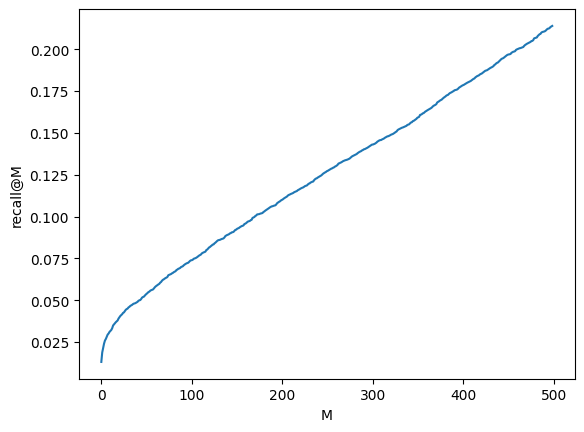

In [ ]:
recall_1_500 = np.mean(recall_matrix,axis=1)
plt.plot(recall_1_500[:-1])
plt.xlabel("M")
plt.ylabel("recall@M")
plt.show()